In [ ]:
## Electric Field Potential Simulation -- Relaxation & MultiGrid
#Phys 290 Final
#Felix W.

In [1]:
#General Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import astropy.units as u
import scipy.signal as signal
import scipy.ndimage as ndi
from field import Field
from field import NoneMethod
import matplotlib 

In [2]:
# The "Field" Class

# Here we introduce our very own Field class that allows us to simulate electric fields 
# from given charge densities and conductors at known voltages

# To define a Field object we need to set a resolution, and our simulation dimensions, and their respective units

res = 1000
dim = [[-3,3],[-3,3]]
dimunits=u.m
fieldunits=u.V

f = Field(res, dim, dimunits, fieldunits, np.vectorize(NoneMethod))

# Note: the 5th argument allows us to piecewise produce a known field if we have equations for it already,
# however we use NoneMethod to produce a fully zero array

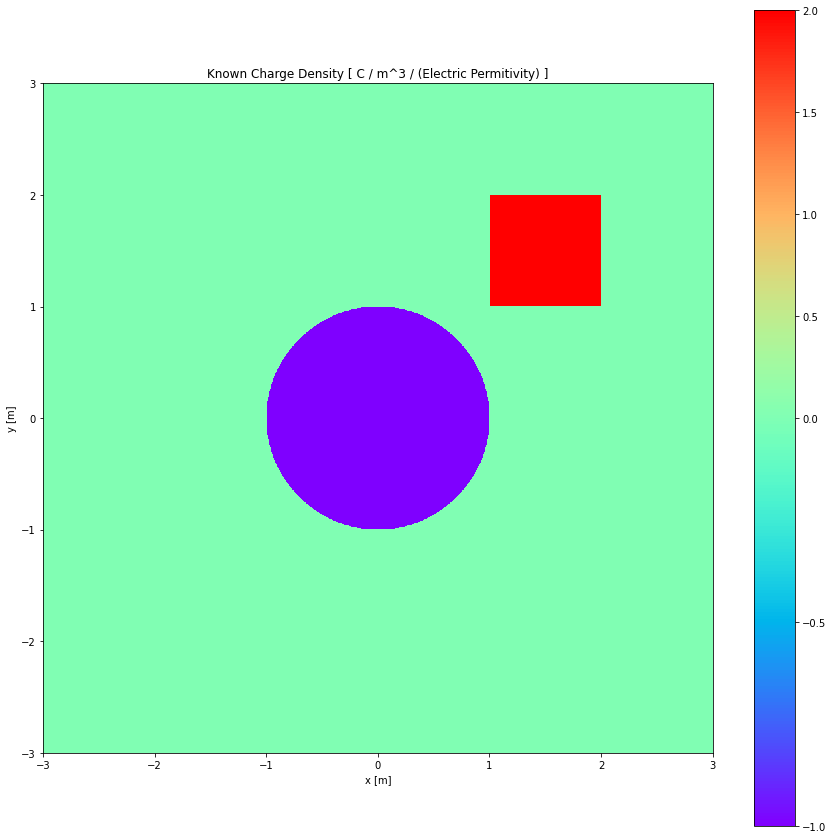

In [3]:
# Inputting known Charge Densities

# To input a known charge density, we can do this using a distribution specified through a function:

def Charge(x,y):
    
    r2 = (x)**2 + y**2
    
    if (np.abs(x-1.5)<0.5)&(np.abs(y-1.5)<0.5):
        return 2
    elif r2 < 1:
        return -1
    else:
        return 0

# In this case the output units of Charge are in [ C / m^3 / (Electric Permitivity) ]

# Since -charge/permitivity is equal to the laplace of the voltage field, we set it as our field's 
# reference laplace array using the lap_ref() method

f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Charge))

# To help visualize relevant information neatly, a plot() method also exists to help us visualize all the fields 'Field' produces

f.plot(-f.lapref, name='Known Charge Density [ C / m^3 / (Electric Permitivity) ]')

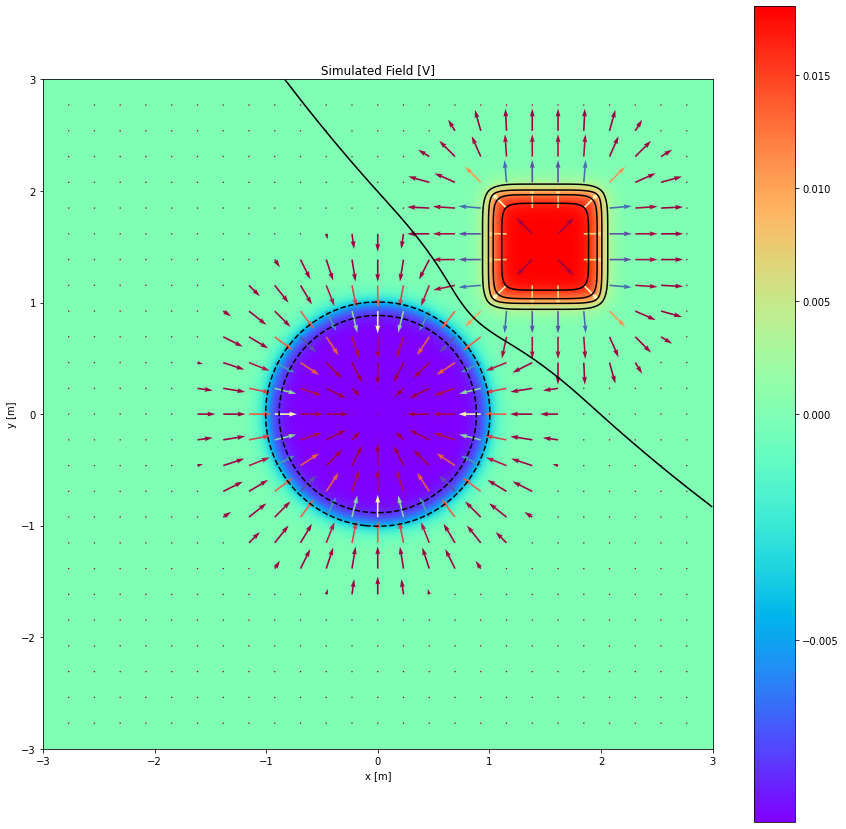

In [4]:
# Solving Poisson's Equation using the relaxation method - How not to do it

# A basic relaxation scheme can be used on each cell, but this can be rather slow and computationally ineffecient (as you can see when you run this cell)
# This can be referenced using the relax(n) method, where n = # of iterations to be done

f.relax(1000)  # THIS IS GOING TO TAKE AWHILE

# Our result can then be plotted:

f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field [V]")

# Turns out it's a pretty bad result -- especially given how long the calculation took
# In fact, we can see that the field has only been "simulated" a certain distance away from our known charges - a sign that we haven't 'relaxed' enough
# How do we get around this??

Calculating Step:  1
Calculating Step:  2
Calculating Step:  3
Calculating Step:  4
Calculating Step:  5
Calculating Step:  6


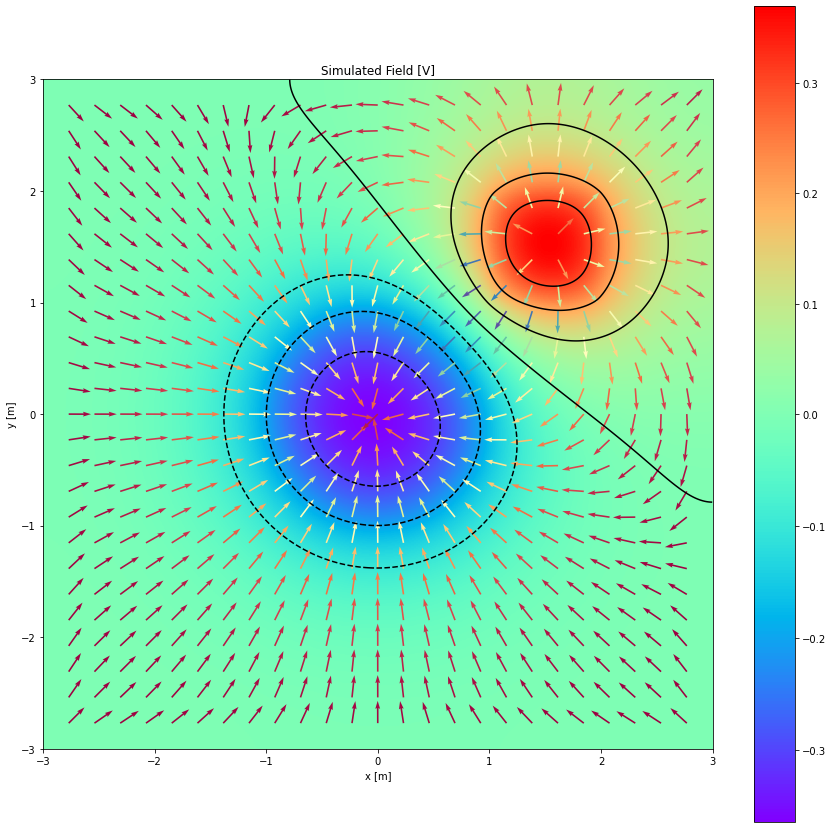

In [4]:
# Multi-Grid Approach

# Resampling our field to lower resolutions will allow for quicker calculations using a multi-grid approach
# this can be done with MultiSolve(depth, n)

# depth is an array of the resampling factors (e.g. a factor of 10 => solving over an array 1/10 in length & width) 
# in order of operation. 

# n can be either an integer or an array of integers specifying the # of iterations per step, respectively

# We can also use the keyword argument 'progress' to notify us when its calculating a step

f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[400,200,200,200,100,50,20], progress = True)

f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field [V]")

# As we can see this is much faster and more accurate!!

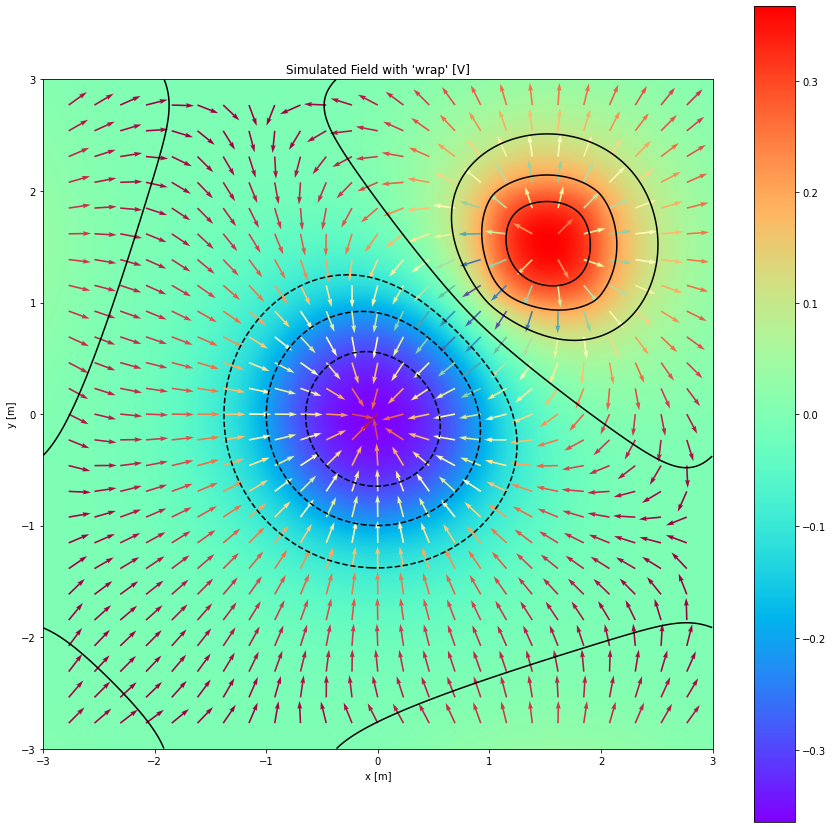

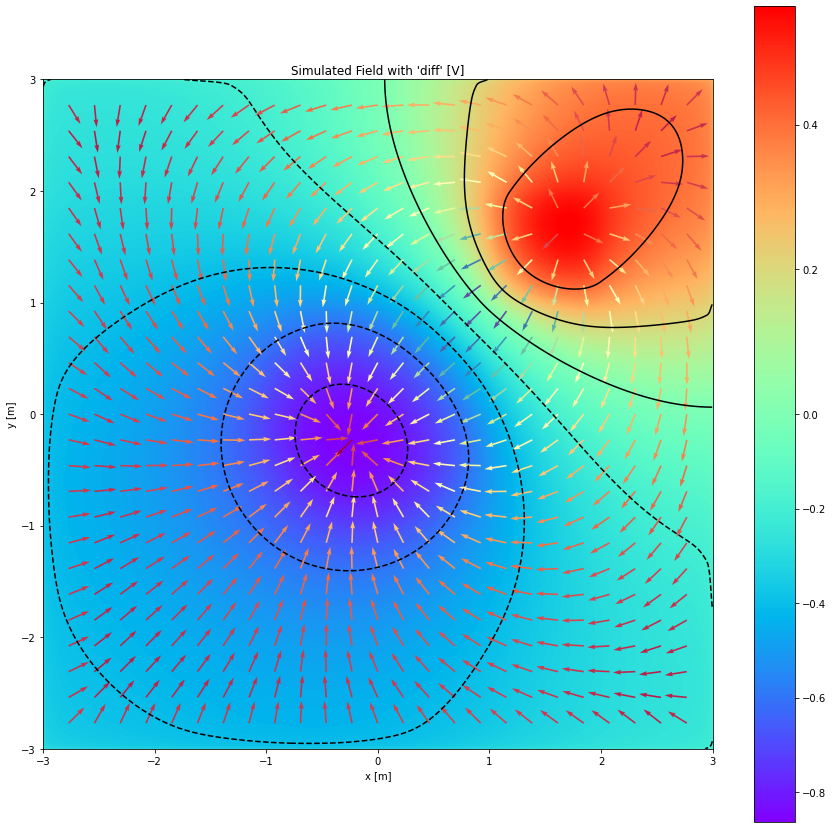

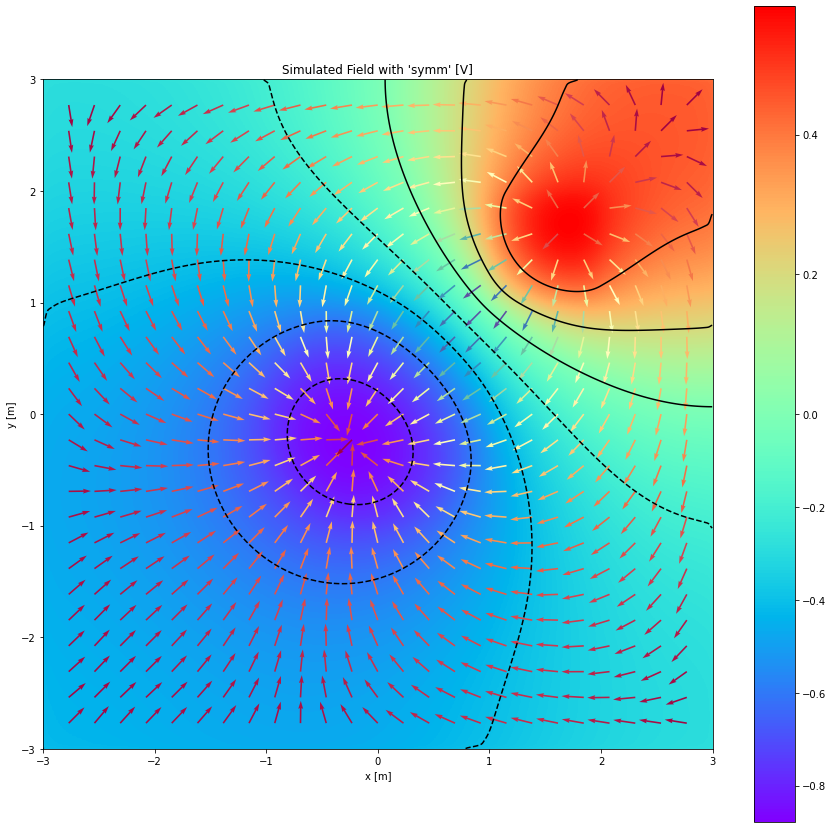

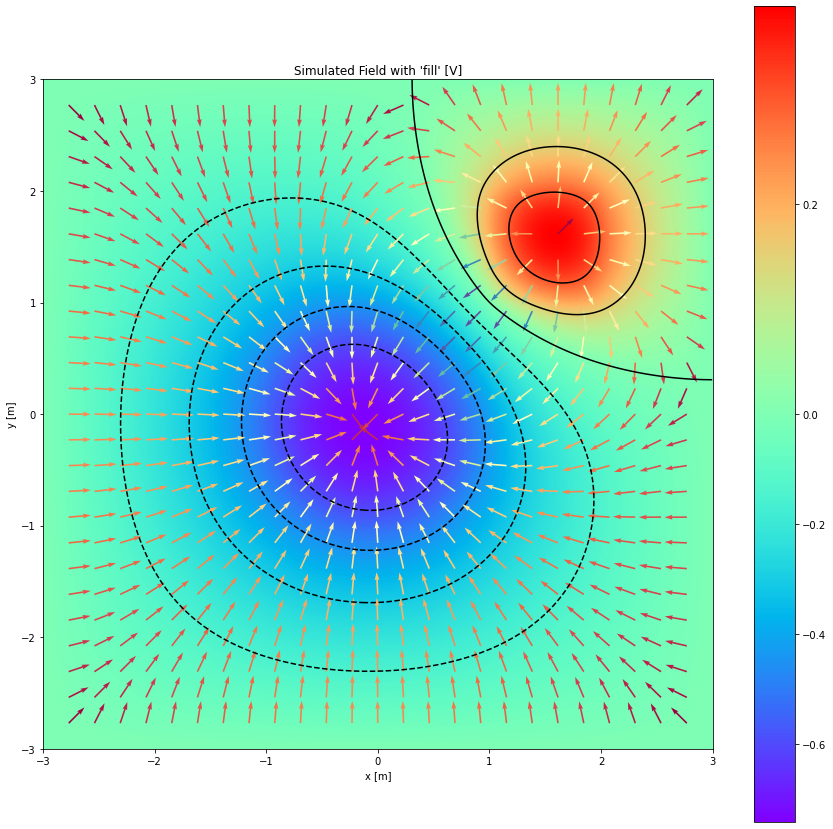

In [5]:
# A Note on boundary conditions

# To effeciently do a relaxation step, the Field object makes use of the scipy.signal.convolve2d function
# However, this built in function has only certain boundary conditions available: 'wrap', 'symm', 'fill'

# 'fill' assumes a constant (given) potential outside our simulation space (assumed to be 0)
# 'wrap' solves assuming periodic symmetry outside our simulation space
# 'symm' assumes a reflecting boundary condition (effectively the same as a dV/dx = 0 boundary)

# As none of these represent the usual scenario of being in open space, a fourth option was written for the Field class:

# 'diff' expands the field by one step in all directions using a 4th-order accurate finite difference; convolve2d is run over the expanded array and then the inner array
#        is returned, effectively working around boundary assumtions of convolve2d! 
#        Note: Lower order accurate differencing schemes can cause low convergence and added boundary noise, also as it is right now - it's not perfect

# The Field object assumes 'symm', but this can be changed with the keyword argument 'bound' when initializing:

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='wrap')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Charge))
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[400,200,200,200,100,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field with 'wrap' [V]")

# Notice there are important differences between our results! - Especially in the overall voltage levels due to periodic symmetry

# Then to demonstrate the 'diff' method (No Boundary conditions):

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='diff')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Charge))
f.MultiSolve([40,20,10, 8, 6, 4, 3, 2, 1],[400,400,200,200,100,100,50,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field with 'diff' [V]")

# Then to demonstrate the 'symm' method:

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='symm')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Charge))
f.MultiSolve([40,20,10, 8, 6, 4, 3, 2, 1],[400,400,200,200,100,100,50,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field with 'symm' [V]")

# Then to demonstrate the 'fill' method (V=0 at boundaries):

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='fill')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Charge))
f.MultiSolve([40,20,10, 8, 6, 4, 3, 2, 1],[400,400,200,200,100,100,50,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Field with 'fill' [V]")

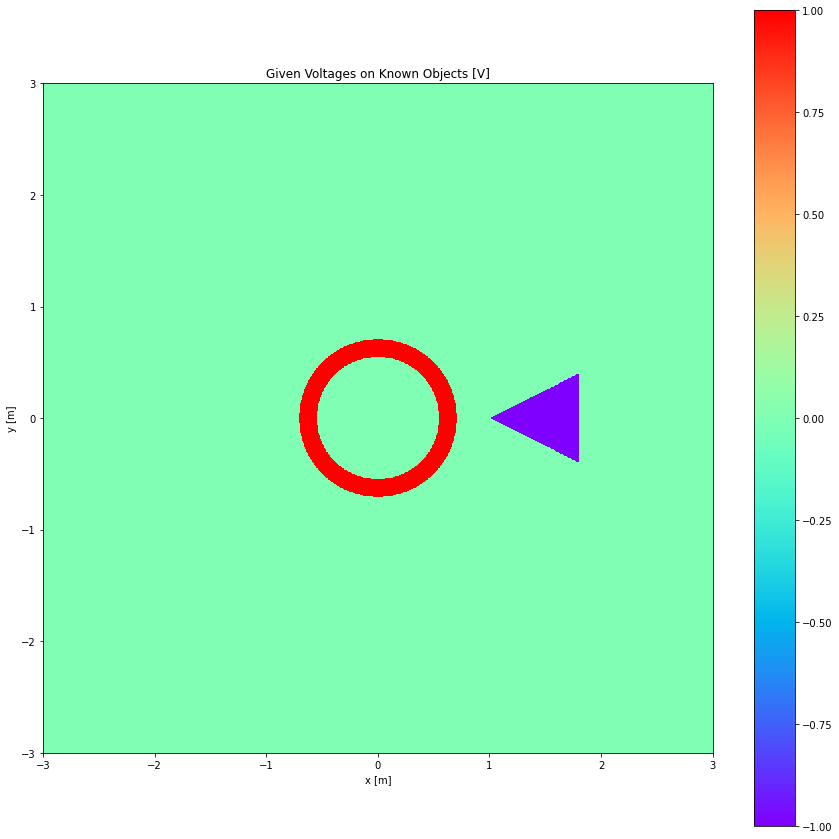

In [6]:
## Calculating Fields from Known Voltages

# Another great feature of the Field class is that we can define local areas of known voltages (non-zero) and solve for the potential using the Poisson
# Equation. Using the addmask() method, the Field class stores the known voltage locations and only runs the relaxation method over unknown regions:

# Note: Using the 'diff' method here will require more computation time to produce a stable result, as large swaths of space will have a non-zero voltage,
# though a smart multigrid search pattern should be able to overcome this. To get quick results to look at certain areas, rather than the overall field, we
# can use other methods like fill or symm.

def Objects(x,y):
    
    r2 = x**2 + y**2
    
    if ((x-2*y-1)>0)&((-x-2*y+1)<0)&(x<1.8):
        return -1
    if (r2>0.3)&(r2<0.5):
        return 1
    else:
        return 0

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='fill')

f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod))
f.addmask(np.vectorize(Objects))

f.plot(f.field, name="Given Voltages on Known Objects [V]")

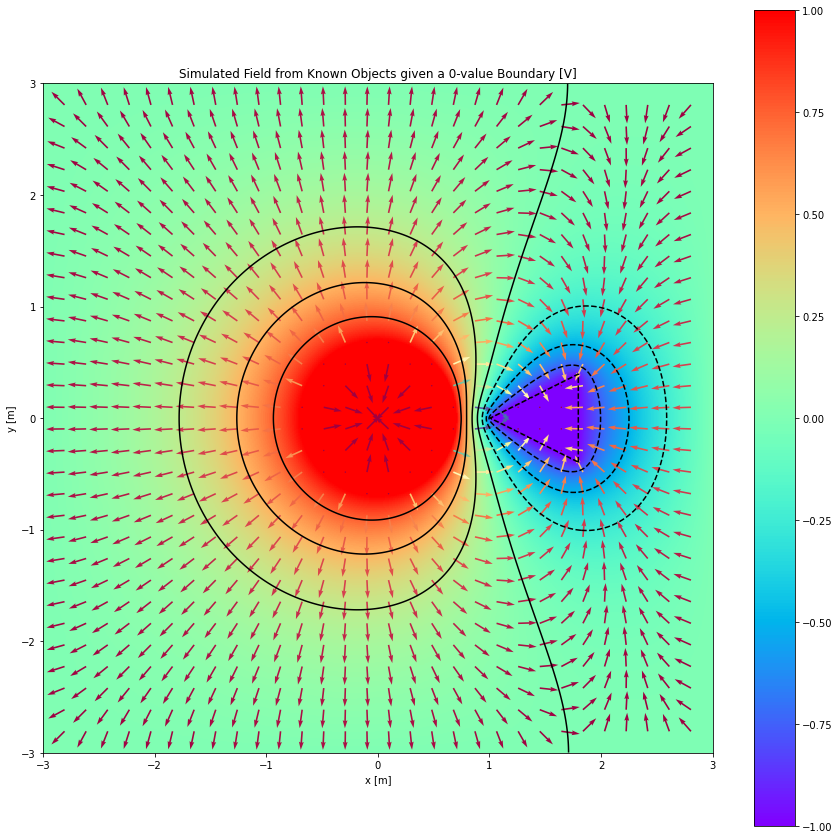

In [7]:
# Now we can solve!

f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[400,400,400,400,100,100,20])

f.plot(f.field, contour=True, vecdim=30, vectors=True, name="Simulated Field from Known Objects given a 0-value Boundary [V]")    

# Note: You may notice that the field inside our shell is not fully constant when vectors are present (as they are all normed)
# This is an issue with convergence, but running another multigrid solver across will help!

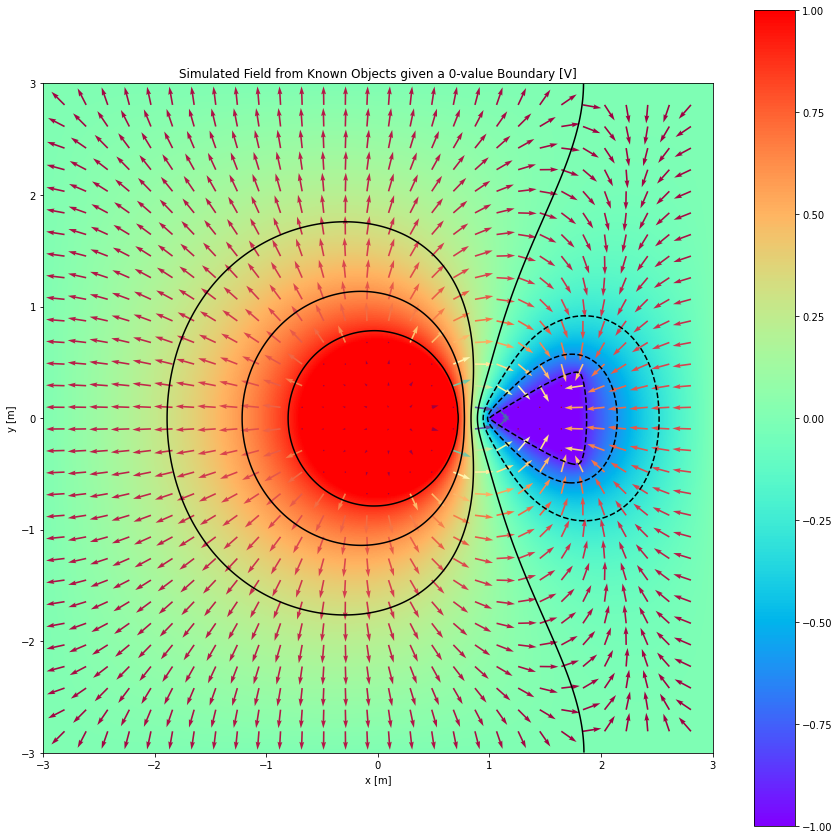

In [8]:
# Running another round of multigrid solving:

f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[400, 400,400,400,100,100,20])

f.plot(f.field, contour=True, vecdim=30, vectors=True, jvec=False, name="Simulated Field from Known Objects given a 0-value Boundary [V]")   

# Hopefully, your result should show a constant potential within the shell!

# This shows us that the multigrid search pattern is also an important consideration when using this type of method
# We can also see the lightning rod effect occuring at the tip of our triangle, where we have the biggest gradient

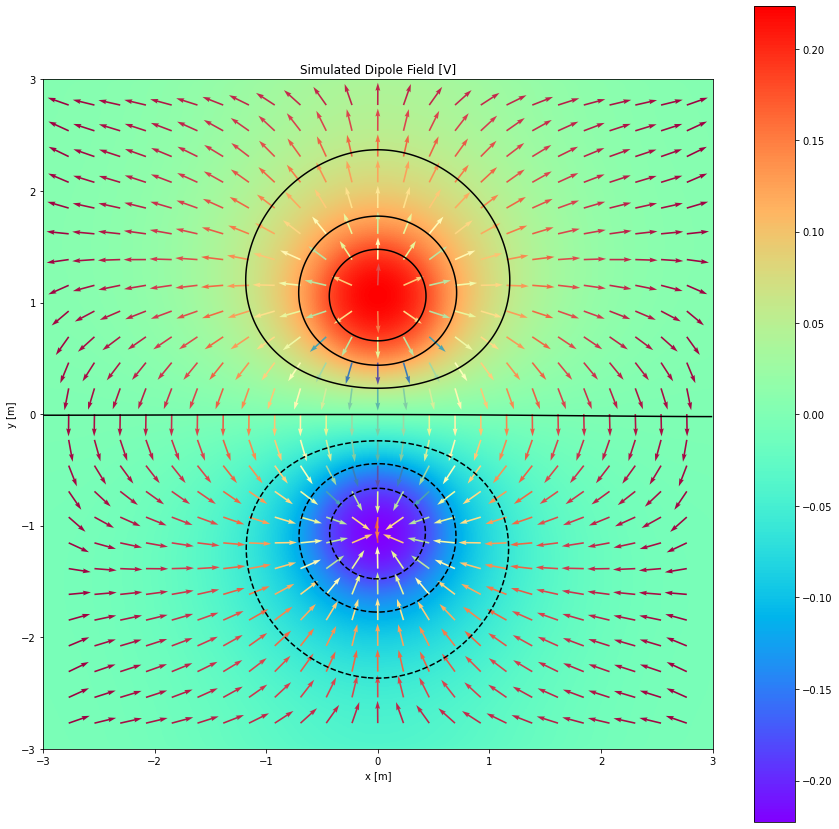

In [9]:
## Some Fun Examples -- Electric Dipole

def Dipole(x,y):
    
    if (x**2 + (y-1)**2)<0.3:
        return 1
    elif (x**2 + (y+1)**2)<0.3:
        return -1
    else:
        return 0

f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='diff')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(Dipole))   
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Dipole Field [V]")

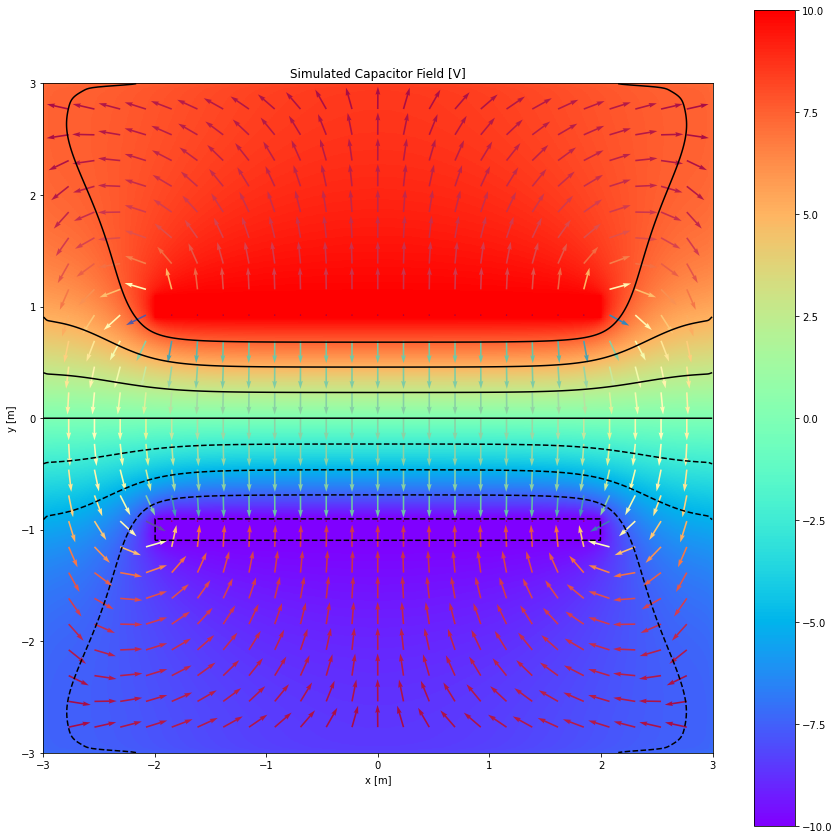

In [10]:
## Some Fun Examples --  Capacitor

def Capacitor(x,y):
    
    if (y<1.1)&(y>0.9)&(np.abs(x)<2):
        return 10
    elif (y<-0.9)&(y>-1.1)&(np.abs(x)<2):
        return -10
    else:
        return 0
    
f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='symm')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod))
f.addmask(np.vectorize(Capacitor))
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.plot(f.field, contour=True, vecdim=25, vectors=True, name="Simulated Capacitor Field [V]")

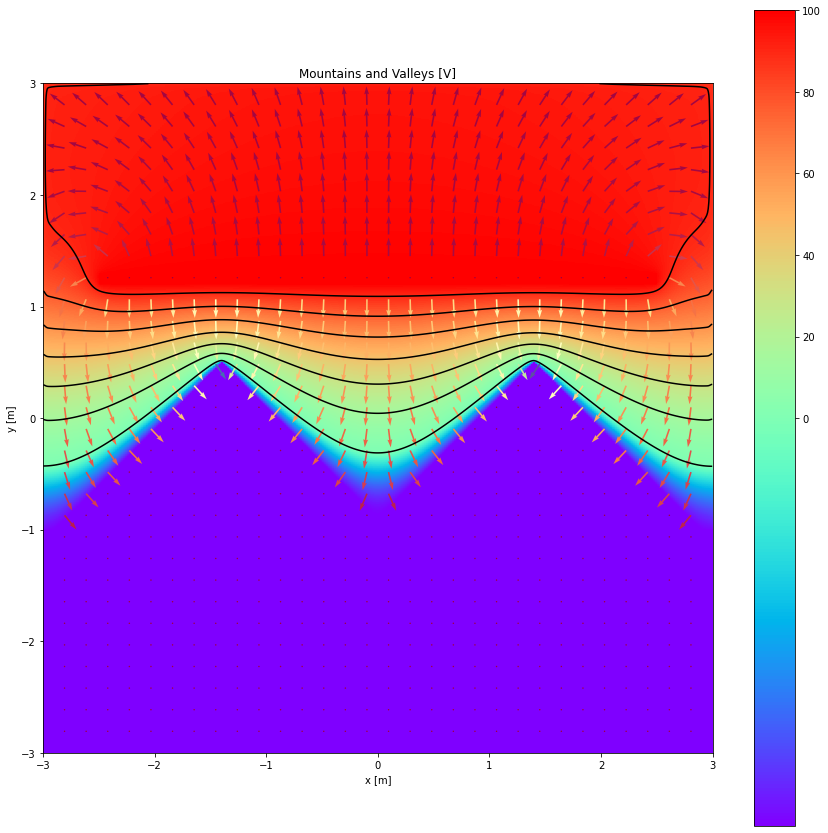

In [11]:
## Mountains and Valleys

def Nature(x,y):
    
    if (y<1.3)&(y>1.2)&(np.abs(x)<2.5):
        return 100
    if (y-(x-1.4) < 0.5)&(y+(x-1.4)<0.5)&(y>-1):
        return -10
    if (y-(x+1.4) < 0.5)&(y+(x+1.4)<0.5)&(y>-1):
        return -10
    if y<-1:
        return -10
    else:
        return 0
    
f = Field(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod), bound='symm')
f.lap_ref(res,dim,dimunits,fieldunits, np.vectorize(NoneMethod))
f.addmask(np.vectorize(Nature))
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.MultiSolve([10, 8, 6, 4, 3, 2, 1],[800,400,400,400,200,50,20])
f.plot(f.field, contour=True, vecdim=30, vectors=True, name="Mountains and Valleys [V]")
    

In [ ]:
# Feel free to play around and what not with this simulator as well - there's a lot of freedom :)

In [ ]:
# I'll note here that the 'diff' method could maybe be improved, as there is a convergence issue when we directly use the first-order dirivative due to 
# certain terms cancelling, essentially producing a 0-value boundary condition. Therefore I've used an arbitrary weight that gets rid of this, but this 
# decreases the rate of convergence near the boundary (which can be seen if you run it yourself). 